In [1]:
import sys
sys.path.append('../')

<center> This notebook is a practical application of the methods expressed in the class contained in "montecarlo_utils". </center> 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from scipy.stats import norm
from typing import List 
from typing import Callable

import time
import warnings

# ignore warnings
warnings.filterwarnings('ignore')

from SDE.bs import BS_Asset
from SDE.basket import Basket,Weighted_Basket
from SDE.utils.random_generation import generate_n_gaussian, build_gaussian_vector, generate_n_gaussian_quasi
from SDE.utils.matrix import Matrix
from SDE.utils import montecarlo_utils as mc

def confirm_run_cell(title = ""):
    confirmation = input(f"-{title}- Are you sure you want to run this cell? (y/n): ").lower()
    if confirmation == "y":
        return True
    else:
        print("Cell execution cancelled.")
        return False

## <center> INPUTS </center>

In [ ]:
################################################################
##################### BASKET DEFINITION ########################
################################################################

risk_free_rate = 0.05
T = 1
strike = 200
nb_asset = 3

# taking real life parameters found above
asset_AAPL = BS_Asset(169.300003,0.20,risk_free_rate)
asset_AMZN = BS_Asset(179,0.32,risk_free_rate)
asset_TSLA = BS_Asset(179.99,0.53,risk_free_rate)
correl_matrix = [[1.000000, 0.884748, 0.827503], [0.884748, 1.000000, 0.793269], [0.827503, 0.793269, 1.000000]]

adjusted_weights = [2*0.196889,2*0.18622,2*0.185195]
my_basket_object = Weighted_Basket(adjusted_weights,[asset_AAPL,asset_AMZN,asset_TSLA],correl_matrix,live_seed=False)

# building estimating function 
payoff = lambda basket_value : np.exp(-risk_free_rate*T) * max(basket_value-strike,0)
h = my_basket_object.h(T, payoff)

nb_simulation = 1000

# <center> Monte Carlo variance reduction methods presentation </center>

In [ ]:
# generating all simulations used to compare performance of MC estimators
brownian_simu_vec_pseudo = my_basket_object.generate_random_values_in_required_format(nb_periods=1)(nb_simulation) #[generate_n_gaussian(nb_asset) for _ in range(nb_simulation)]        # vector of pseudo-random N(0,1)

### Simple estimator

In [ ]:
####### building estimator function #######
simple_estimator = lambda simu_vec : mc.simple_estimator_general(simu_vec,h)

####### computing estimations #######
price_converg_vec_pseudo = []
for i in tqdm(range(len(brownian_simu_vec_pseudo))):
    price_approx_pseudo = simple_estimator(brownian_simu_vec_pseudo[:i+1])
    price_converg_vec_pseudo.append(price_approx_pseudo)

  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▌    | 554/1000 [00:12<00:17, 25.01it/s] 

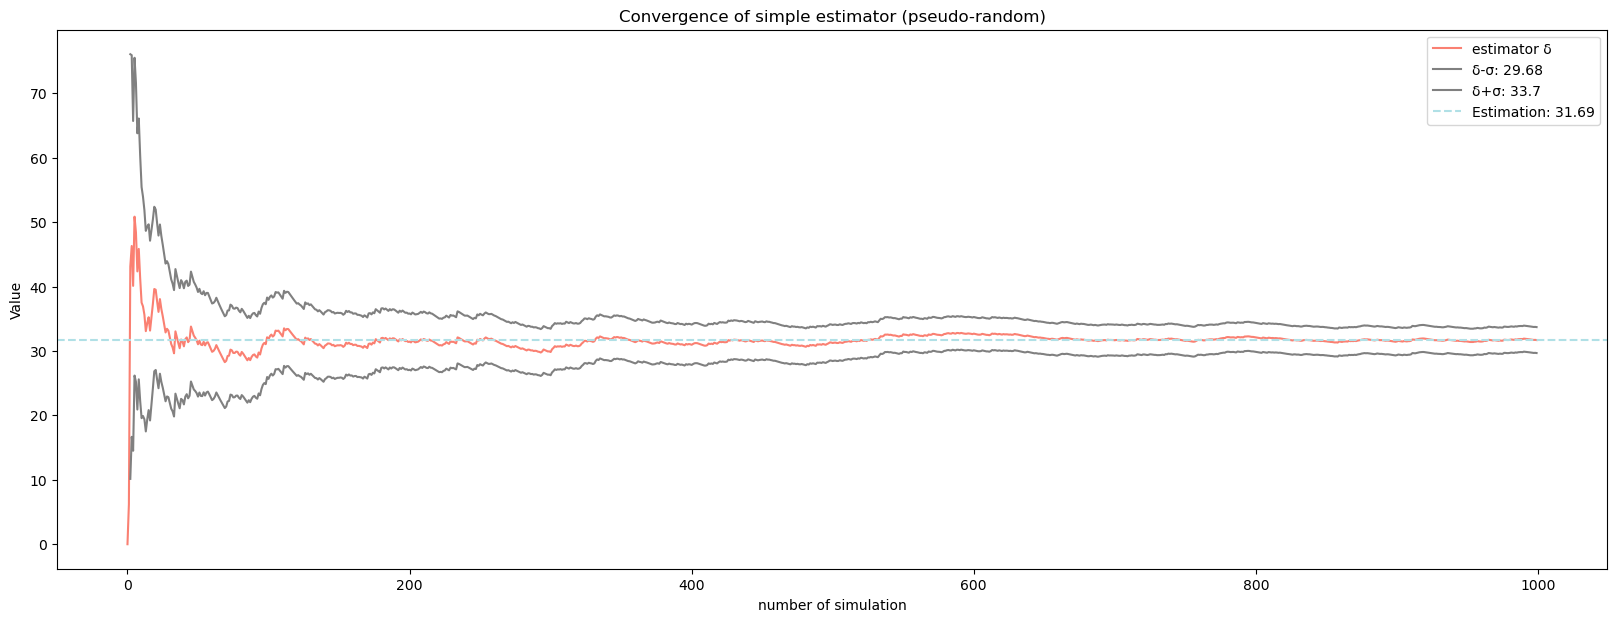

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_pseudo, "Convergence of simple estimator (pseudo-random)")

### Antithetic variate

In [ ]:
####### building estimator function #######
A = lambda x : -x
antithetic_estimator = lambda simu_vec : mc.antithetic_estimator_general(simu_vec,h,A)

####### computing estimations #######
price_converg_vec_anti_pseudo = []
for i in tqdm(range(len(brownian_simu_vec_pseudo))):
    price_approx_anti_pseudo = antithetic_estimator(brownian_simu_vec_pseudo[:i+1])
    price_converg_vec_anti_pseudo.append(price_approx_anti_pseudo)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:46<00:00, 21.74it/s]


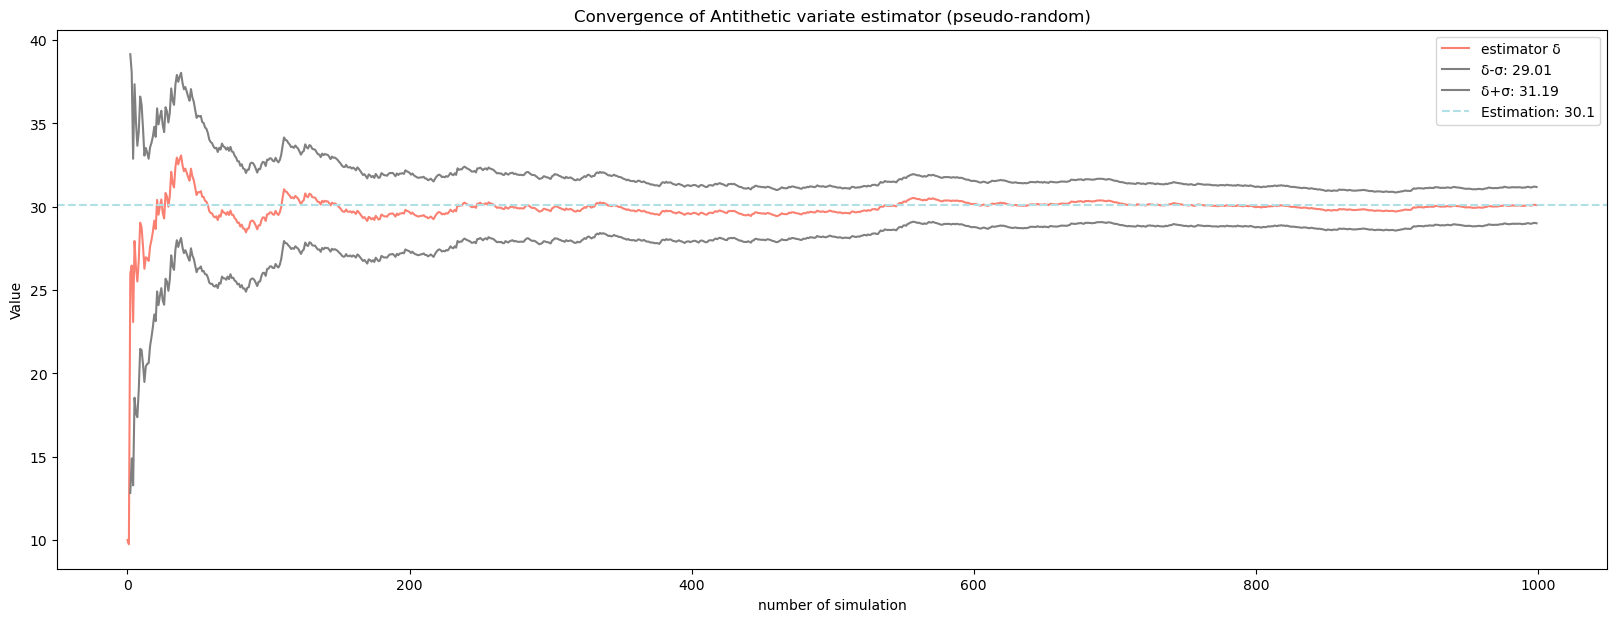

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_anti_pseudo, "Convergence of Antithetic variate estimator (pseudo-random)")

### Control variate

### BONUS : proof of control variate function
Let's prove using monte carlo approximation that the analytical solution we found for E[h0(X)] is appropriated 

In [ ]:
from scipy.stats import norm

####### PARAMETERS #######
_s1 = 0.25
_s2 = 0.25
_correl = 1
_S0 = 100
_r = 0
_T = 1
_alpha1 = 1/2
_alpha2 = 1/2
_K = 100
_covar_matrix = np.array([[_s1**2,_correl*_s1*_s2],[_correl*_s1*_s2,_s2**2]])

####### COMPUTE ANALYTICAL SOLUTION #######
mu_star = np.array([_alpha1*_s1*np.sqrt(_T),_alpha2*_s2*np.sqrt(_T)])
sigma_star = np.sqrt(np.dot(np.dot(mu_star.T,_covar_matrix),mu_star))
cst = np.exp(_alpha1*(np.log(_S0)+(_r-_s1**2/2)*_T)+_alpha2*(np.log(_S0)+(_r-_s2**2/2)*_T))   

d1 = np.log(cst/_K)/sigma_star + sigma_star
d2 = d1 - sigma_star

m = (cst*np.exp(0.5*sigma_star**2)*norm.cdf(d1) - _K*norm.cdf(d2))*np.exp(-_r*_T)

####### COMPUTE E[h0(X)] USING MC #######
def h0(vec_2_brownian):
    w1,w2 = vec_2_brownian
    
    cst = np.exp(_alpha1*(np.log(_S0)+(_r-_s1**2/2)*_T)+_alpha2*(np.log(_S0)+(_r-_s2**2/2)*_T))   
    b_val = np.exp(_alpha1*_s1*np.sqrt(_T)*w1+_alpha2*_s2*np.sqrt(_T)*w2)  

    return np.exp(-_r*_T)*max(cst*b_val-_K,0)

n_sim = 100000
mean_val_h0 = np.mean([h0(build_gaussian_vector(Matrix(_covar_matrix),generate_n_gaussian(2,live_seed=True))) for _ in tqdm(range(n_sim))])

################ RESULTS ################
print(f"""
=================== RESULTS ==================
            number of sim : {n_sim}
 MC estimator of E[h0(X)] : {mean_val_h0}
      analytical solution : {m}
==============================================
""")

100%|██████████| 100000/100000 [00:02<00:00, 46823.12it/s]


=================== RESULTS ==================
            number of sim : 100000
 MC estimator of E[h0(X)] : 0.0
      analytical solution : 1.2783883028956673



### Control variate function

In [ ]:
def m_function(basket_object:Basket,r,K,T):
    """
    computing E[h0(X)] for given basket and values
    """
    covar_matrix = basket_object.assetND.correl_matrix.m
    mu_star = np.array([alpha_i*a.vol*np.sqrt(T) for alpha_i,a in zip(basket_object.weights,basket_object.assetND.assets)])
    sigma_star = np.sqrt(np.dot(np.dot(mu_star.T,covar_matrix),mu_star))
    cst = np.exp(np.sum([alpha_i*(np.log(a.initial_spot)+(a.rf-a.vol**2/2)*T) for alpha_i,a in zip(basket_object.weights,basket_object.assetND.assets)]))   

    d1 = np.log(cst/K)/sigma_star + sigma_star
    d2 = d1 - sigma_star

    m = (cst*np.exp(0.5*sigma_star**2)*norm.cdf(d1) - K*norm.cdf(d2))*np.exp(-r*T)
    return m

def h0(brownian_vec,basket_object:Basket,T,payoff_function:Callable)-> Callable:
    """
    ** ATTENTION ** : payoff_function must be actualised if applying 
    
    payoff_function (func): payoff function computing the price for given underlying terminal values
    Returns : 
        returns functions h0((w1,..wd)) = payoff_function applied for log method for the given simulations to the basket

        >>> output : (w1,..,wd) -> exp(sum(alpha_i*S_T_i)) = Mult(X_T(w_i)**alpha_i)
    """
    return payoff_function(basket_object.log_simulate_with_brownian(T,brownian_vec))

####### building estimator function #######
payoff = lambda basket_value : np.exp(-risk_free_rate*T)*max(basket_value-strike,0)
h0_generic = lambda brownian_vec : h0(brownian_vec,my_basket_object,T,payoff)
m_value = m_function(my_basket_object,risk_free_rate,strike,T)

In [ ]:
####### building estimator function #######
control_estimator = lambda simu_vec : mc.control_estimator_general(simu_vec,h,h0_generic,m_value)

####### computing estimations #######
price_converg_vec_cont_pseudo = []
for i in tqdm(range(len(brownian_simu_vec_pseudo))):
    price_approx_cont_pseudo = control_estimator(brownian_simu_vec_pseudo[:i+1])
    price_converg_vec_cont_pseudo.append(price_approx_cont_pseudo)

100%|██████████| 1000/1000 [02:21<00:00,  7.05it/s]


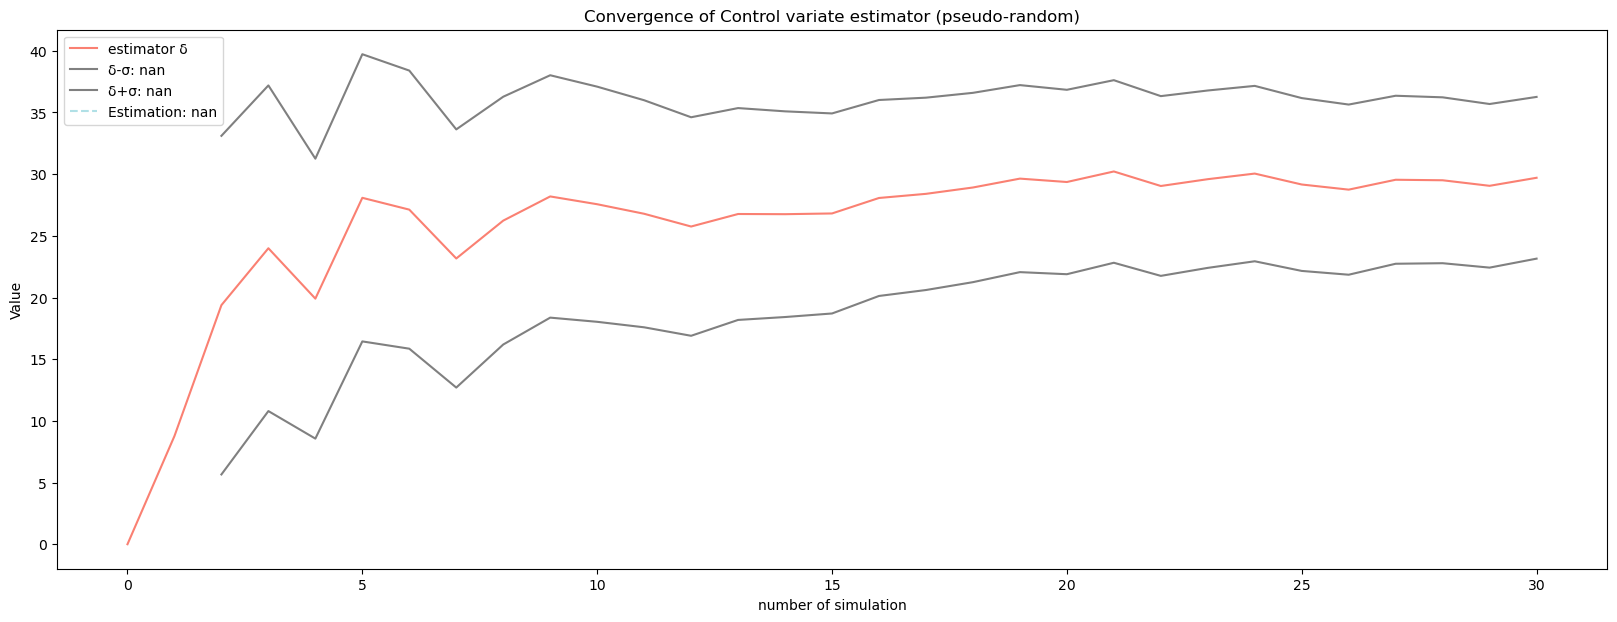

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_cont_pseudo, "Convergence of Control variate estimator (pseudo-random)")

### Control + Antithetic variate

In [ ]:
####### building estimator function #######
control_antithetic_estimator = lambda simu_vec : mc.control_antithetic_estimator_general(simu_vec,h,h0_generic,m_value,A)

####### computing estimations #######
price_converg_vec_cont_anti_pseudo = []
for i in tqdm(range(len(brownian_simu_vec_pseudo))):
    price_approx_cont_anti_pseudo = control_antithetic_estimator(brownian_simu_vec_pseudo[:i+1])
    price_converg_vec_cont_anti_pseudo.append(price_approx_cont_anti_pseudo)

100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s]


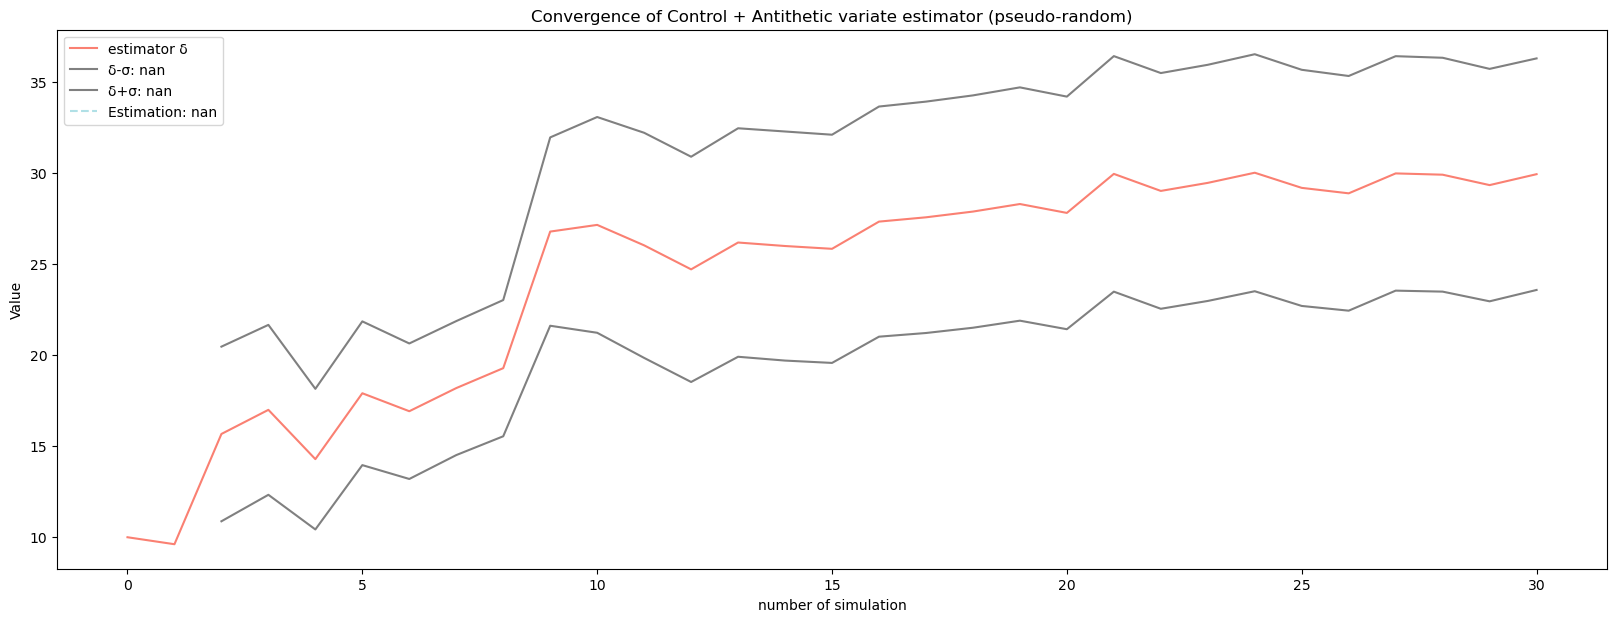

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_cont_anti_pseudo, "Convergence of Control + Antithetic variate estimator (pseudo-random)")

## <center> Monte Carlo variance reduction methods result comparison </center>

### Results

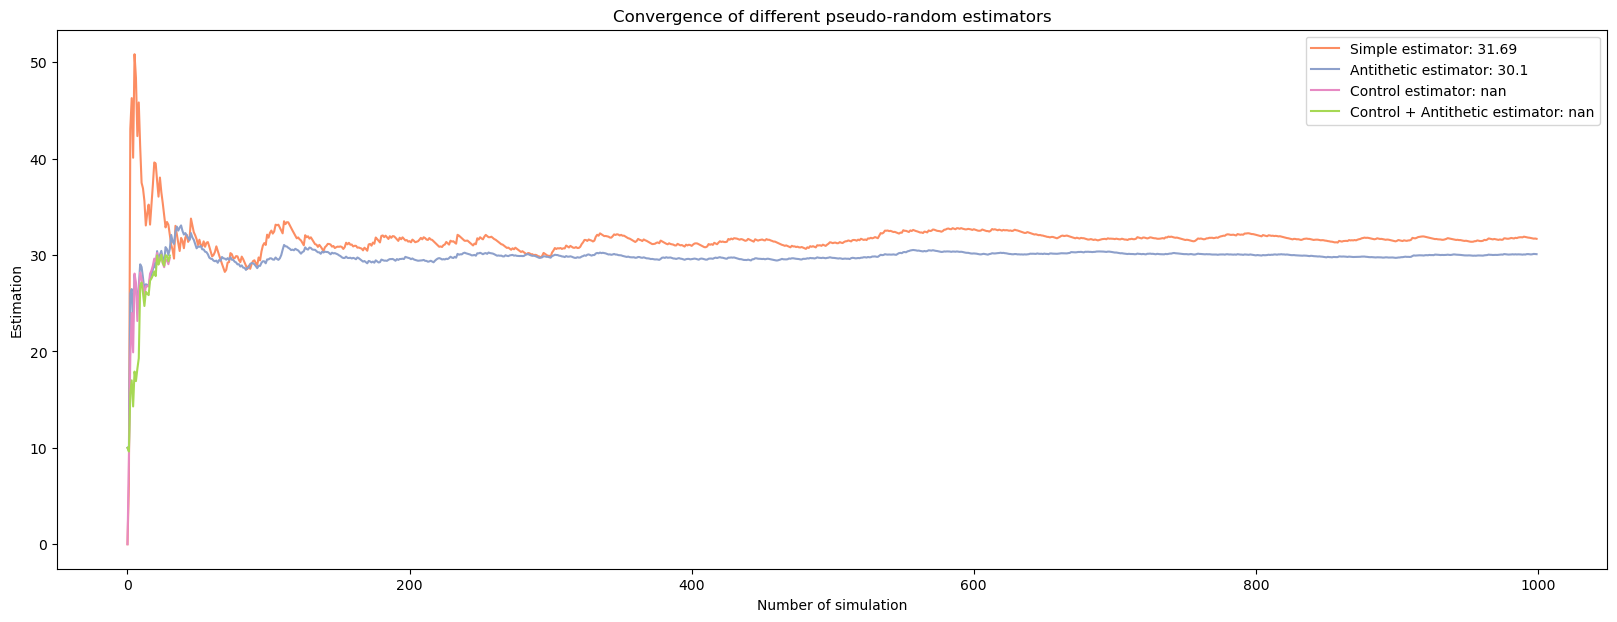

ValueError: Axis limits cannot be NaN or Inf

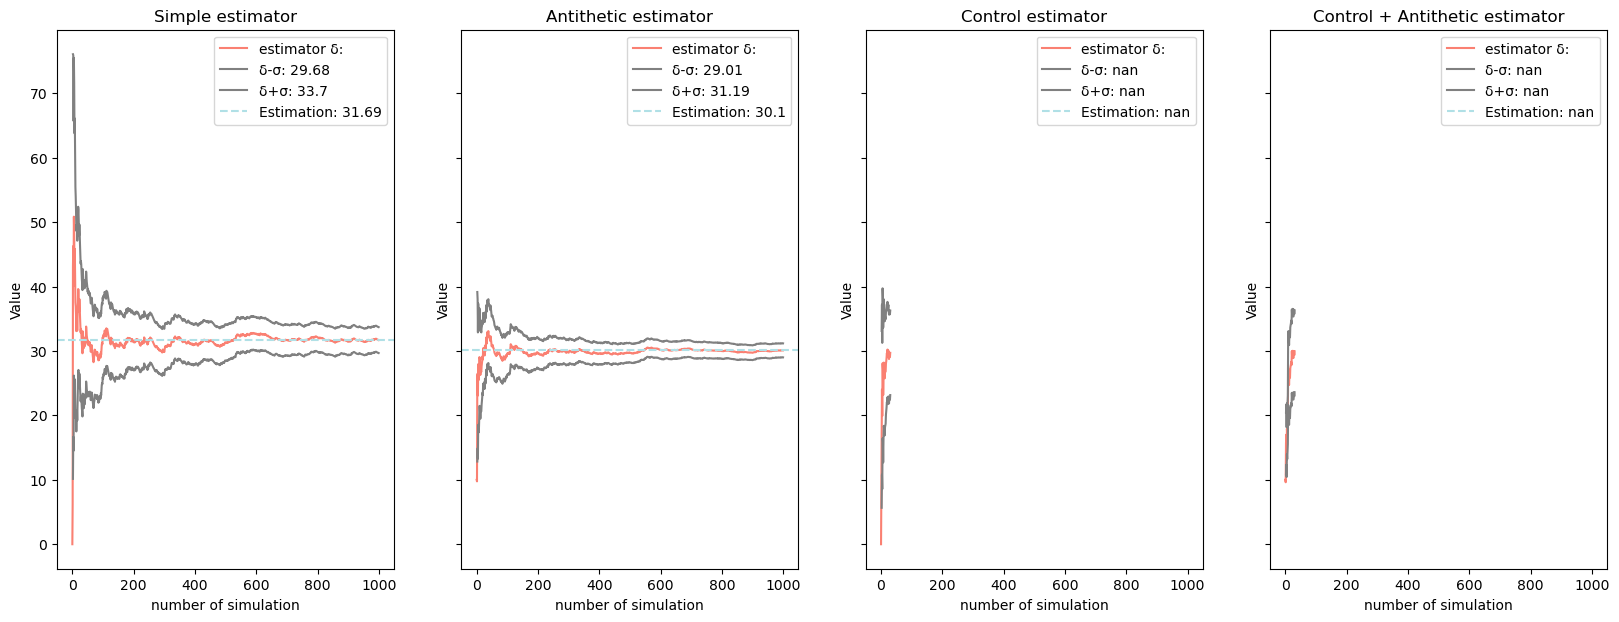

In [ ]:
results_dict = {"Simple estimator": price_converg_vec_pseudo,
                "Antithetic estimator": price_converg_vec_anti_pseudo,
                "Control estimator": price_converg_vec_cont_pseudo,
                "Control + Antithetic estimator": price_converg_vec_cont_anti_pseudo}

mc.display_multi_estimators(results_dict, "Convergence of different pseudo-random estimators")
mc.display_multi_estimators_IC(results_dict, "Convergence of different pseudo-random estimators")

### Variance & Running time

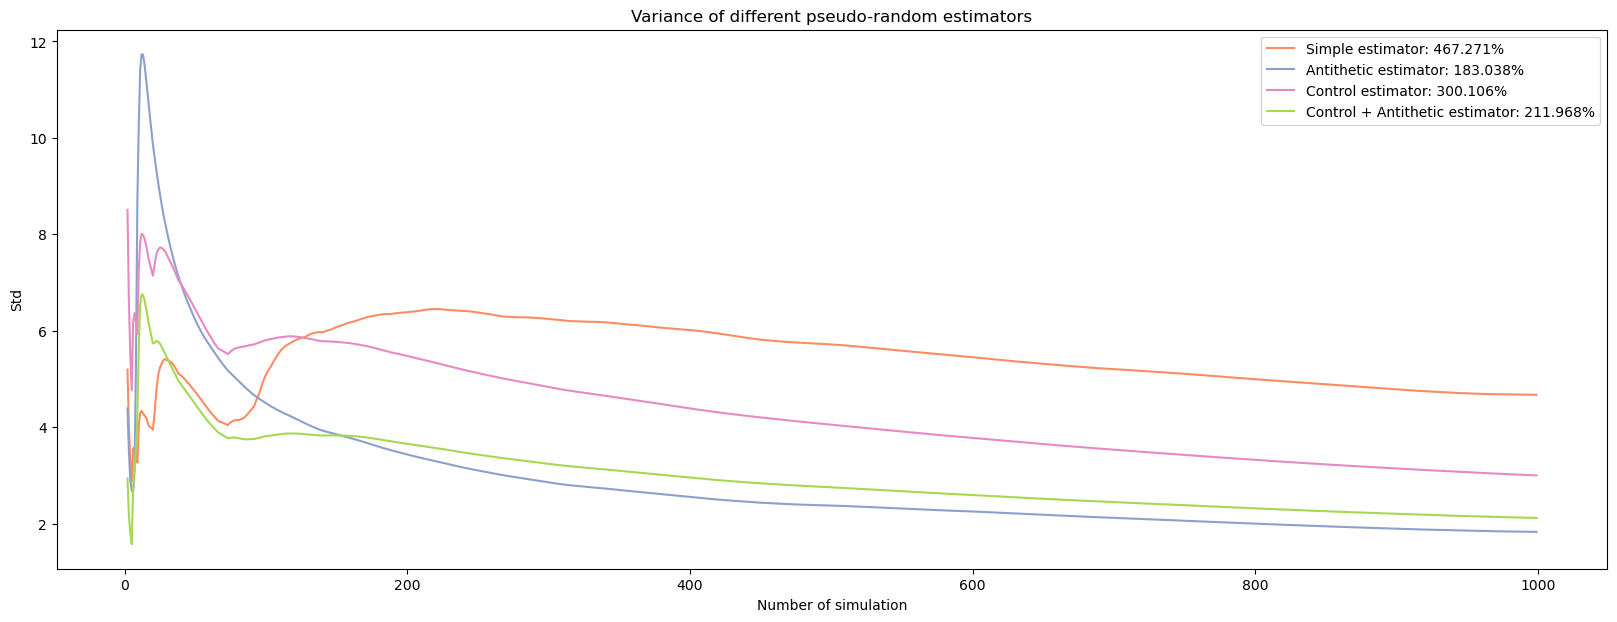

In [ ]:
results_dict = {"Simple estimator": price_converg_vec_pseudo,
                "Antithetic estimator": price_converg_vec_anti_pseudo,
                "Control estimator": price_converg_vec_cont_pseudo,
                "Control + Antithetic estimator": price_converg_vec_cont_anti_pseudo}

mc.display_multi_variance_estimators(results_dict, "Variance of different pseudo-random estimators")

Cell execution cancelled.


***** Number of simulations = 4797 | tol = 3.9999 ******: : 4747it [08:56,  8.85it/s]



        ================ RESULTS : SIMPLE ================
                    tolerance : 4
        number of simulations : 4797
                    run time : 206 ms
        


***** Number of simulations = 525 | tol = 3.9998 ******: : 475it [00:13, 35.32it/s]



        ============== RESULTS : ANTITHETIC ==============
                    tolerance : 4
        number of simulations : 525
                    run time : 48 ms
        


***** Number of simulations = 416 | tol = 3.9991 ******: : 366it [00:25, 14.54it/s]



        =============== RESULTS : CONTROL ===============
                    tolerance : 4
        number of simulations : 416
                    run time : 117 ms
        


***** Number of simulations = 261 | tol = 3.9964 ******: : 211it [00:19, 10.94it/s]



        =========== RESULTS : CONTROL & ANTI. ===========
                    tolerance : 4
        number of simulations : 261
                    run time : 148 ms
        


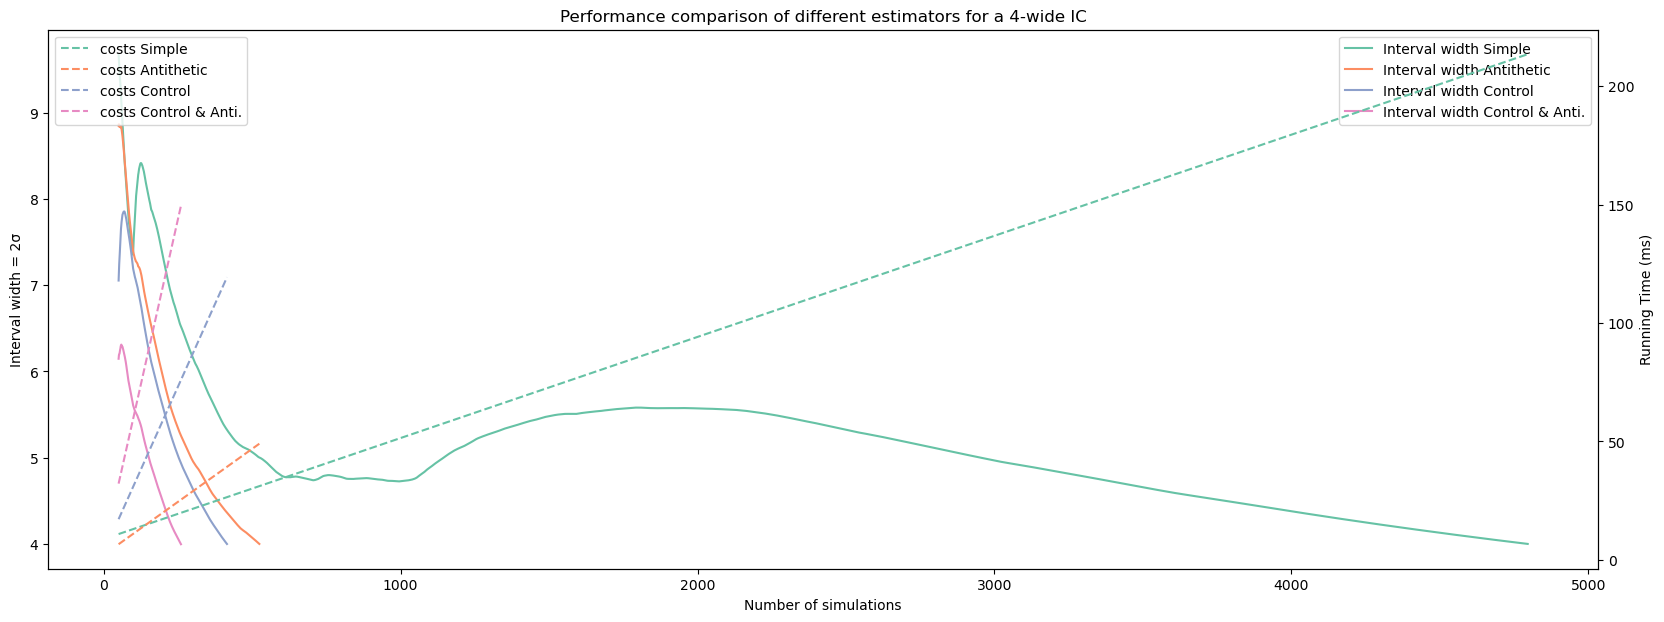

In [ ]:
###### SINGLE COMPARISON ######
interval_width = 4

if confirm_run_cell("Comparison perf individually"):
    mc.compute_performance_estimators(nb_asset,simple_estimator,interval_width)                ## simple estimator
    mc.compute_performance_estimators(nb_asset,antithetic_estimator,interval_width)            ## antithetic estimator
    mc.compute_performance_estimators(nb_asset,control_estimator,interval_width)               ## control variate estimator
    mc.compute_performance_estimators(nb_asset,control_antithetic_estimator,interval_width)    ## control & Anti. variate estimator

####### MULTI COMPARISON ######
if confirm_run_cell("Comparison perf simultaneously"):
    function_dict = {"Simple": simple_estimator,
                    "Antithetic": antithetic_estimator,
                    "Control": control_estimator,
                    "Control & Anti.": control_antithetic_estimator}

    mc.compute_performance_multi_estimators(nb_asset,function_dict,interval_width)

In [ ]:
print(price_converg_vec_pseudo[-1])
print(price_converg_vec_anti_pseudo[-1])
print(price_converg_vec_cont_pseudo[-1])
print(price_converg_vec_cont_anti_pseudo[-1])

31.69228242551363
31.215857547624356
30.77582750874493
30.870616026634444


# <center> Quasi Monte Carlo variance reduction methods presentation </center>

In [ ]:
# generating all simulations used to compare performance of MC estimators
brownian_simu_vec_quasi = generate_n_gaussian_quasi(nb_asset, nb_simulation)         # vector of quasi-random N(0,1)

### Simple estimator

In [ ]:
####### building estimator function #######
simple_estimator = lambda simu_vec : mc.simple_estimator_general(simu_vec,h)

####### computing estimations #######
price_converg_vec_quasi = []
for i in tqdm(range(len(brownian_simu_vec_quasi))):
    price_approx_quasi = simple_estimator(brownian_simu_vec_quasi[:i+1])
    price_converg_vec_quasi.append(price_approx_quasi)

100%|██████████| 1000/1000 [00:21<00:00, 45.79it/s]


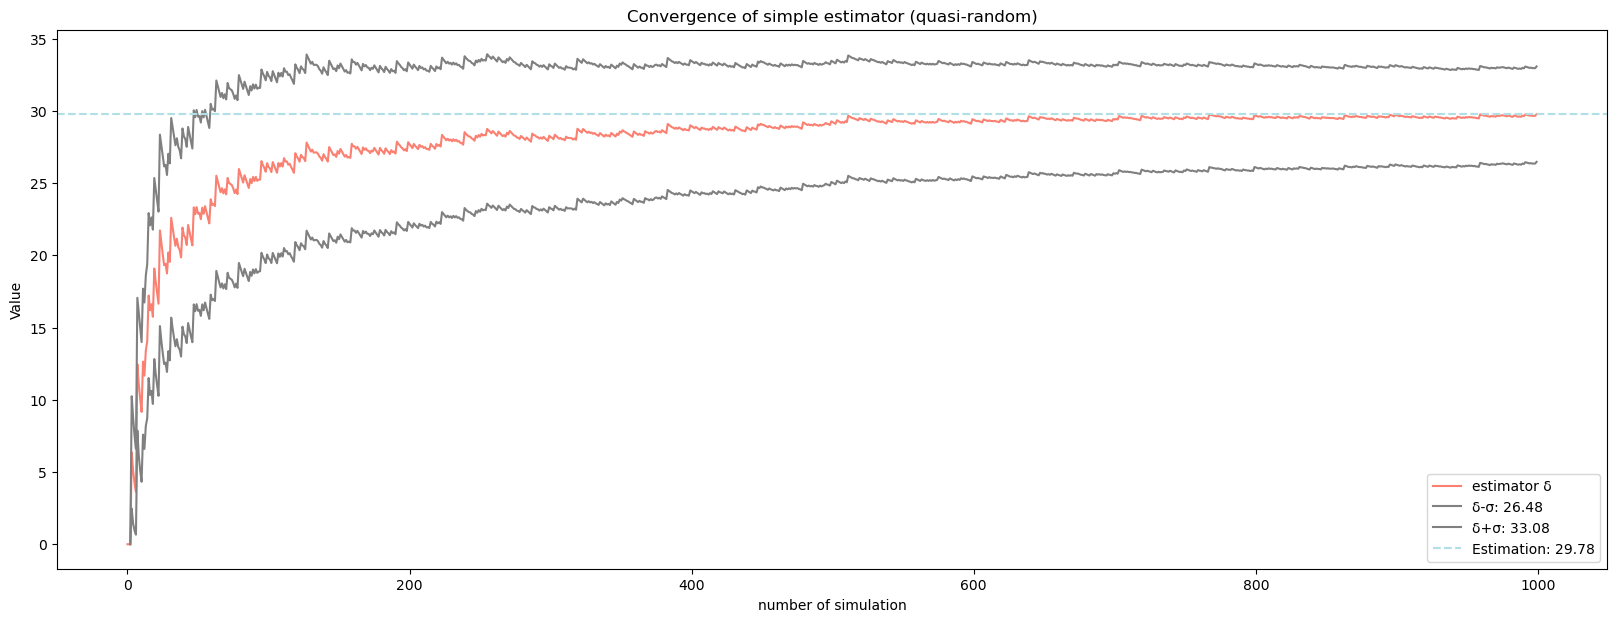

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_quasi, "Convergence of simple estimator (quasi-random)")

### Antithetic variate

In [ ]:
####### building estimator function #######
A = lambda x : -x
antithetic_estimator = lambda simu_vec : mc.antithetic_estimator_general(simu_vec,h,A)

####### computing estimations #######
price_converg_vec_anti_quasi = []
for i in tqdm(range(len(brownian_simu_vec_quasi))):
    price_approx_anti_quasi = antithetic_estimator(brownian_simu_vec_quasi[:i+1])
    price_converg_vec_anti_quasi.append(price_approx_anti_quasi)

100%|██████████| 1000/1000 [00:44<00:00, 22.58it/s]


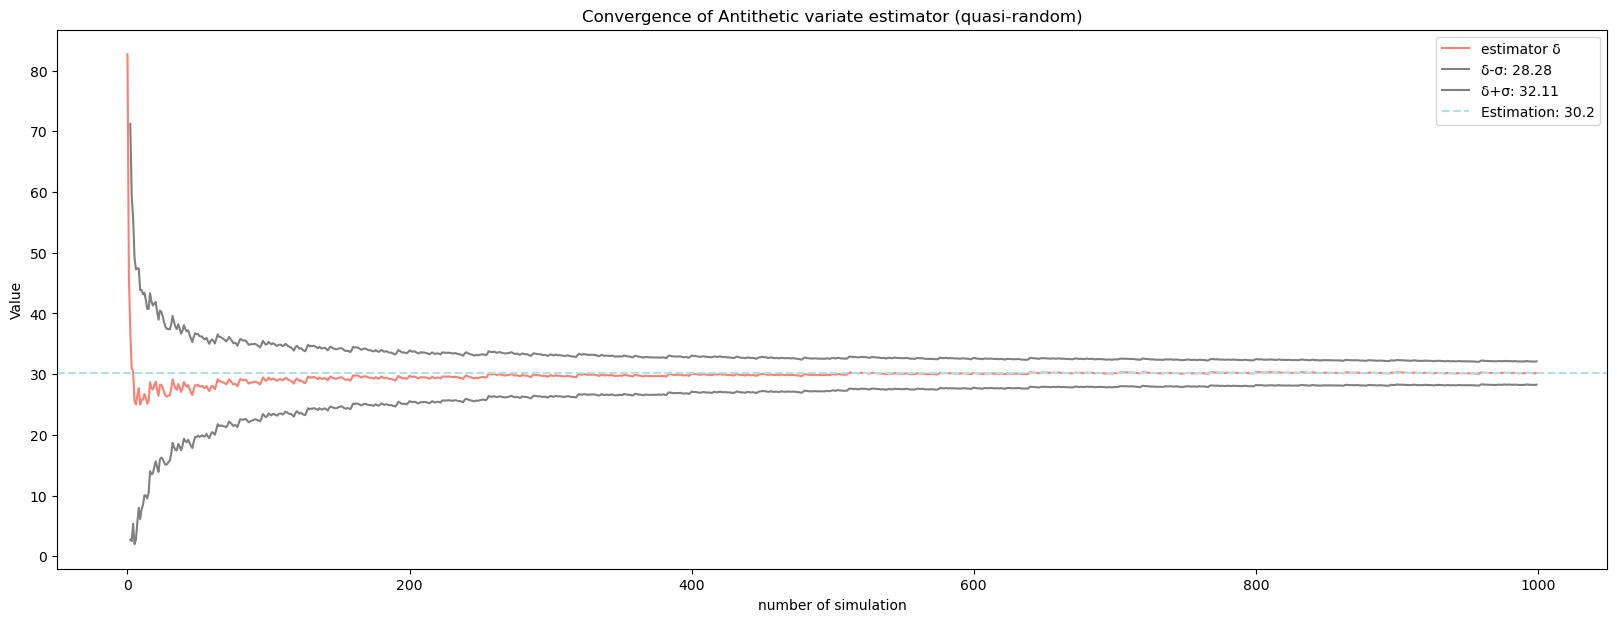

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_anti_quasi, "Convergence of Antithetic variate estimator (quasi-random)")

### Control variate

In [ ]:
####### building estimator function #######
control_estimator = lambda simu_vec : mc.control_estimator_general(simu_vec,h,h0_generic,m_value)

####### computing estimations #######
price_converg_vec_cont_quasi = []
for i in tqdm(range(len(brownian_simu_vec_quasi))):
    price_approx_cont_quasi = control_estimator(brownian_simu_vec_quasi[:i+1])
    price_converg_vec_cont_quasi.append(price_approx_cont_quasi)

100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


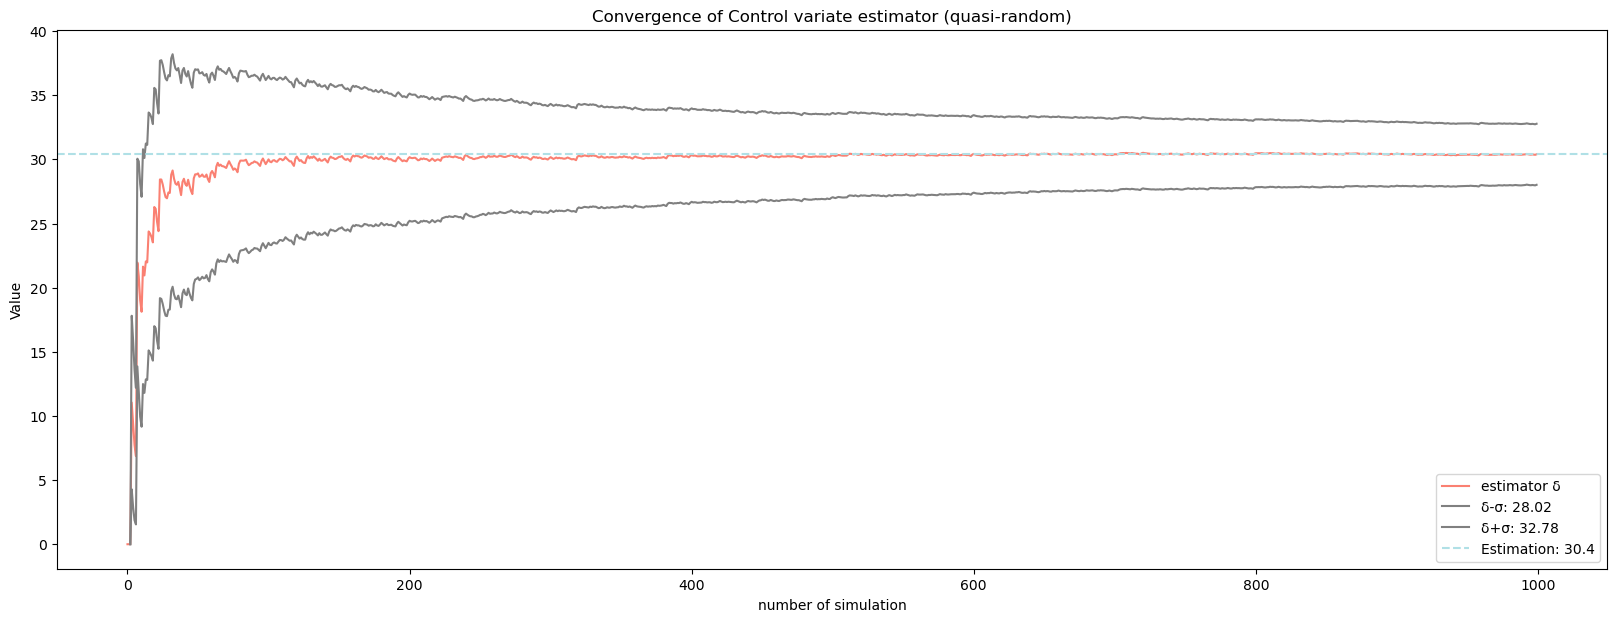

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_cont_quasi, "Convergence of Control variate estimator (quasi-random)")

### Control + Antithetic variate

In [ ]:
####### building estimator function #######
control_antithetic_estimator = lambda simu_vec : mc.control_antithetic_estimator_general(simu_vec,h,h0_generic,m_value,A)

####### computing estimations #######
price_converg_vec_cont_anti_quasi = []
for i in tqdm(range(len(brownian_simu_vec_quasi))):
    price_approx_cont_anti_quasi = control_antithetic_estimator(brownian_simu_vec_quasi[:i+1])
    price_converg_vec_cont_anti_quasi.append(price_approx_cont_anti_quasi)

100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]


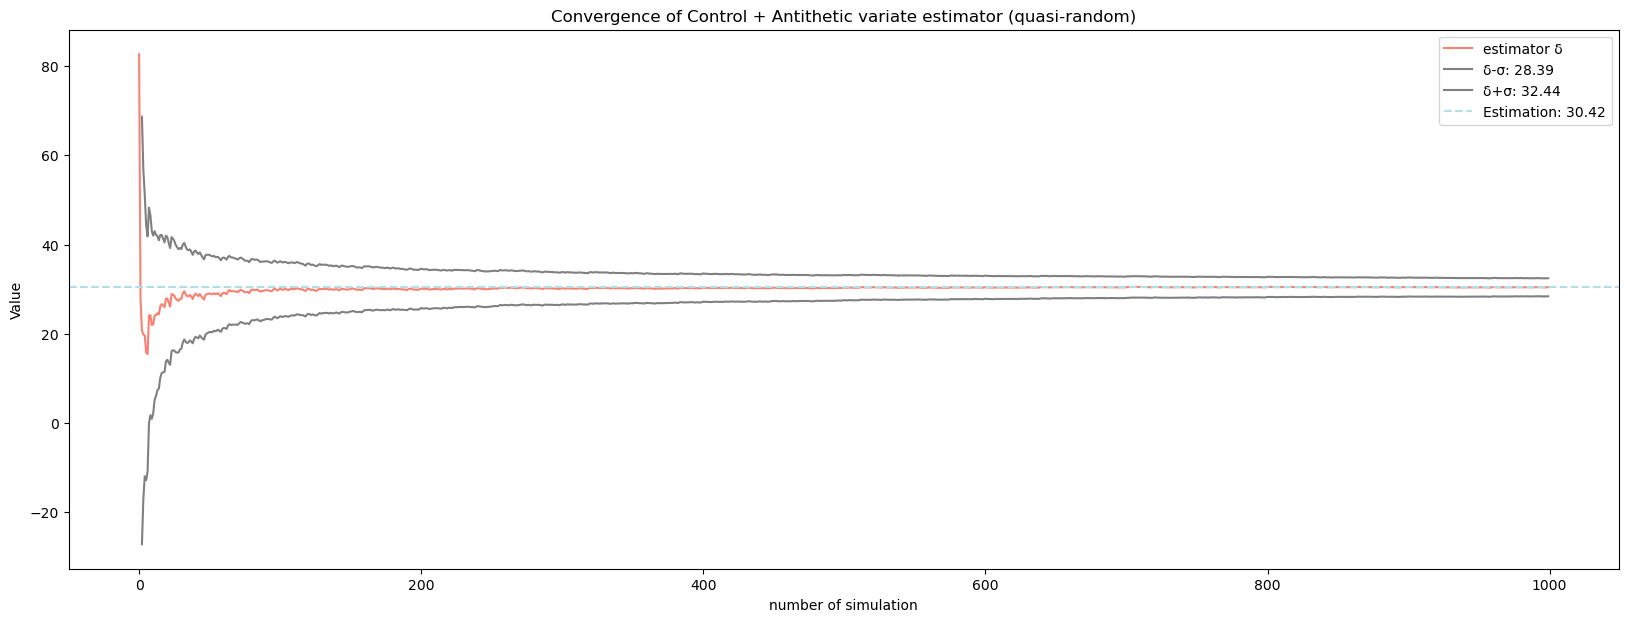

In [ ]:
mc.display_single_estimators_IC(price_converg_vec_cont_anti_quasi, "Convergence of Control + Antithetic variate estimator (quasi-random)")

## <center> Quasi Monte Carlo variance reduction methods result comparison </center>

### Results

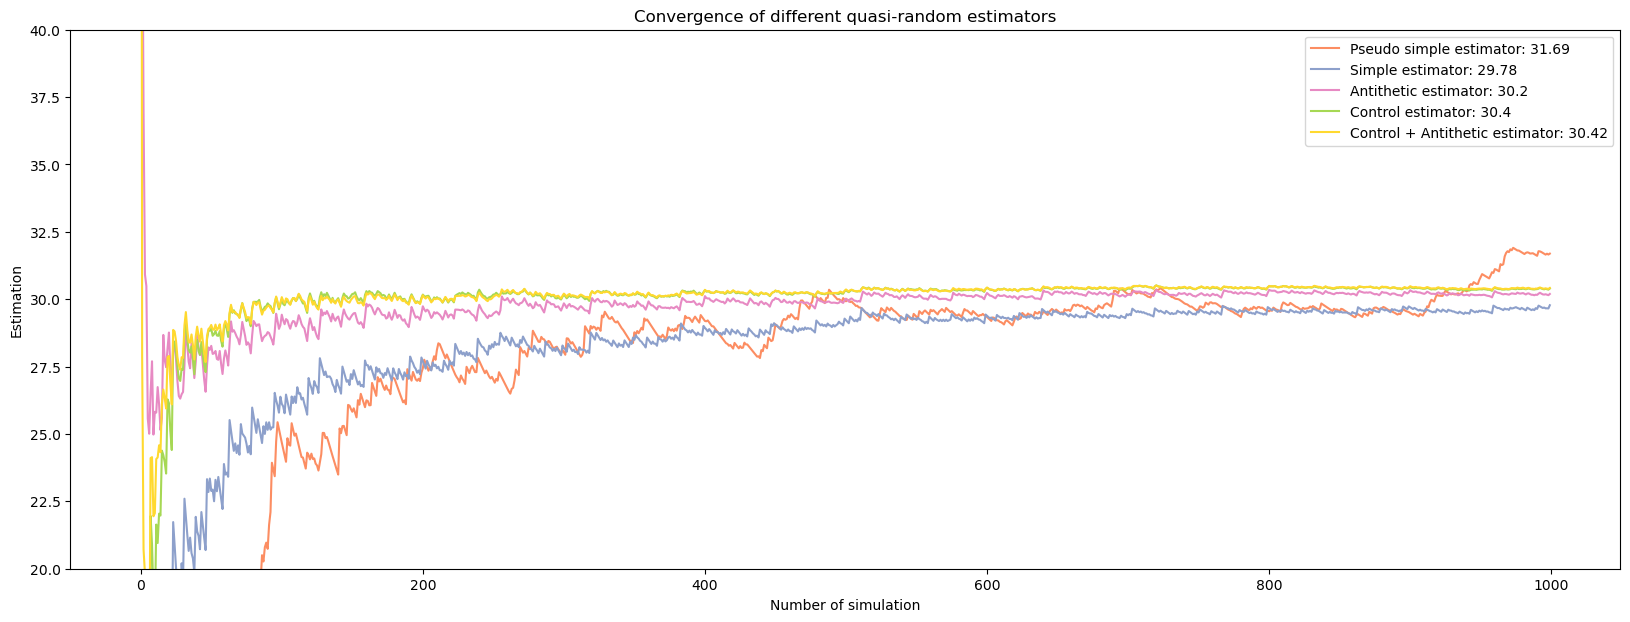

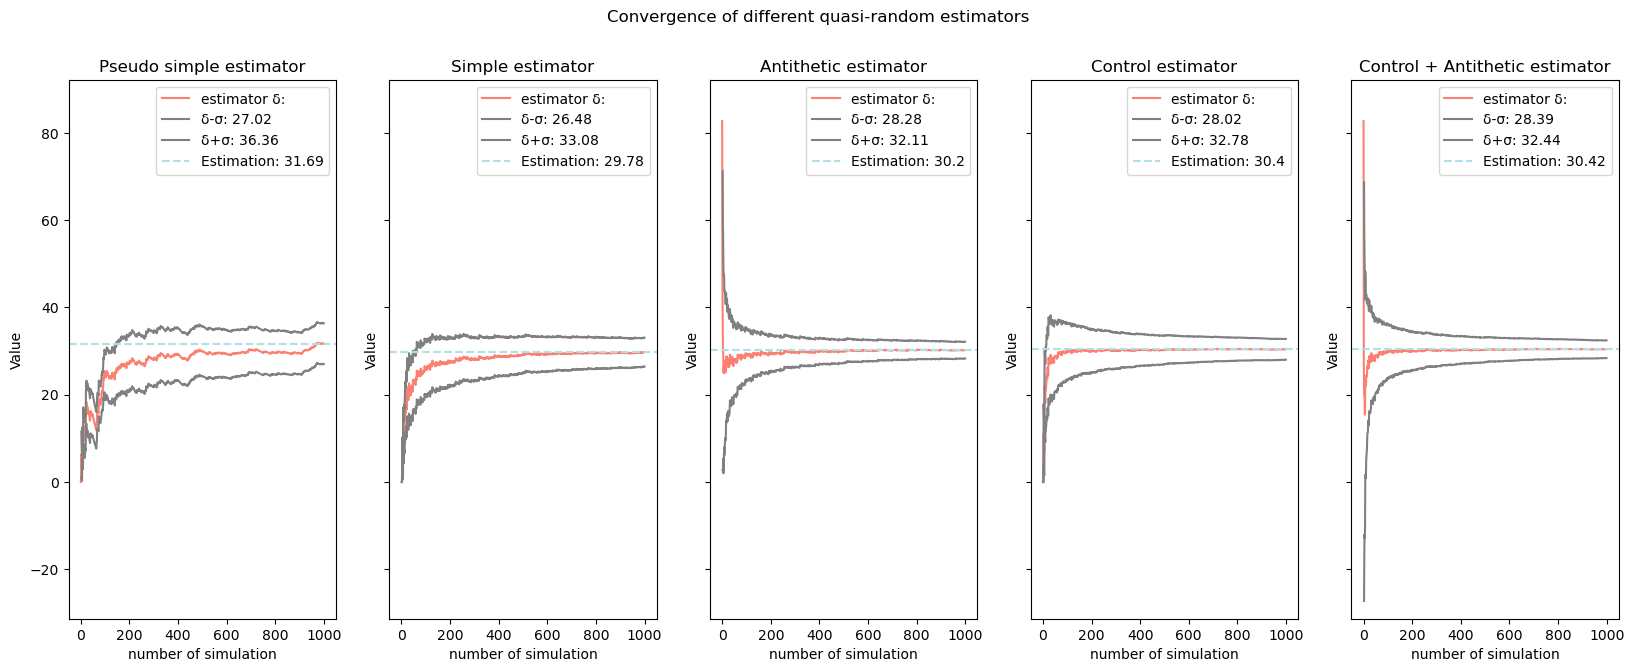

In [ ]:
results_dict = {"Pseudo simple estimator": price_converg_vec_pseudo,
                "Simple estimator": price_converg_vec_quasi,
                "Antithetic estimator": price_converg_vec_anti_quasi,
                "Control estimator": price_converg_vec_cont_quasi,
                "Control + Antithetic estimator": price_converg_vec_cont_anti_quasi}

mc.display_multi_estimators(results_dict, "Convergence of different quasi-random estimators",ylim=(20,40))
mc.display_multi_estimators_IC(results_dict, "Convergence of different quasi-random estimators")

In [ ]:
print(price_converg_vec_quasi[-1])
print(price_converg_vec_anti_quasi[-1])
print(price_converg_vec_cont_quasi[-1])
print(price_converg_vec_cont_anti_quasi[-1])

29.777737213243096
30.195723319202504
30.396743108100157
30.41848358389541


### Variance

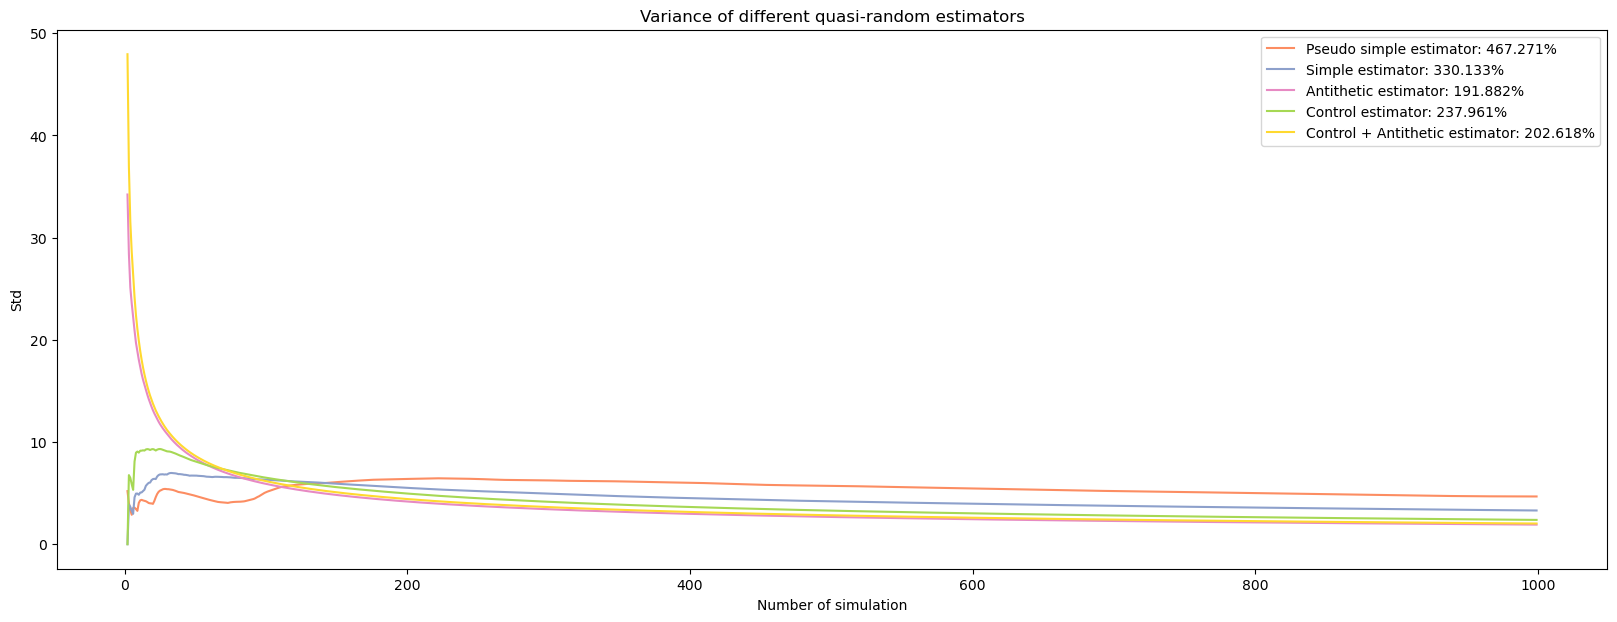

In [ ]:
mc.display_multi_variance_estimators(results_dict, "Variance of different quasi-random estimators")